## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
import torch.optim as optim
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [ ]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [ ]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [ ]:
loader={'train':train_loader,'test':test_loader}

In [ ]:
len(fmnist_dataset_test)

10000

In [ ]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [ ]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), 
            nn.BatchNorm1d(input_shape  * input_channels),
            nn.Dropout(p = 0.2),
            nn.Linear(input_shape  * input_channels, 70),
            nn.ReLU(),
            nn.Linear(70, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
       BatchNorm1d-2                  [-1, 784]           1,568
           Dropout-3                  [-1, 784]               0
            Linear-4                   [-1, 70]          54,950
              ReLU-5                   [-1, 70]               0
            Linear-6                   [-1, 10]             710
Total params: 57,228
Trainable params: 57,228
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.22
Estimated Total Size (MB): 0.24
----------------------------------------------------------------


Your experiments come here:

In [ ]:
def train_model(model, max_epochs = 20):

    accuracy = {"train": [], "test": []}
    cross = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(max_epochs):
        for k, dataloader in loader.items():
            y_tr=torch.Tensor().to(device)
            y_pr=torch.Tensor().to(device)
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in tqdm(dataloader, leave=False, desc=f"{k} iter:"):
                x_batch=x_batch.to(device)
                y_batch=y_batch.to(device)
                if k == "train":
                    model.train()
                    optimizer.zero_grad() 
                    outp = model(x_batch)
                    loss = cross(outp, y_batch) 
                    loss.backward() 
                    optimizer.step()  
                else:
                    model.eval() 
                    with torch.no_grad():
                        outp = model(x_batch)
                    y_tr=torch.cat((y_tr,y_batch),0)    
                    y_pr=torch.cat((y_pr,outp.argmax(-1)),0)
                preds=outp.detach().argmax(-1)
                correct =int(torch.sum(preds==y_batch))
                all = y_batch.shape[0] 
                epoch_correct += correct
                epoch_all += all
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
            if k=="test":
                y_tr=y_tr.to('cpu').numpy()
                y_pr=y_pr.to('cpu').numpy()
                f1_sc=f1_score(y_tr, y_pr, average='macro')
                print(f'\t\tf1_score: {f1_sc}')
    return accuracy

In [ ]:
def plot_graph(accuracy, epochs = 20):
    fig, ax = plt.subplots()
    ax.plot(range(epochs), accuracy['train'], 'b', label='train', linewidth=2)
    ax.plot(range(epochs), accuracy['test'], 'g', label='test', linewidth=2)
    ax.legend()
    fig.set_figheight(9)
    fig.set_figwidth(12)
    ax.set_title("Accuracy")
    plt.show()

In [ ]:
model = TinyNeuralNetwork().to(device)
res = train_model(model)

train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.8187833333333333


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8497
		f1_score: 0.8496243888343054


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 2
Loader: train. Accuracy: 0.8597166666666667


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.86
		f1_score: 0.8584902796504394


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 3
Loader: train. Accuracy: 0.8715


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc43c62de50>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7fc43c62de50>
AssertionError
: Traceback (most recent call last):
can only test a child process
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Loader: test. Accuracy: 0.868
		f1_score: 0.8673125916109543


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 4
Loader: train. Accuracy: 0.8786


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8709
		f1_score: 0.8713044405352992


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 5
Loader: train. Accuracy: 0.8837333333333334


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8753
		f1_score: 0.8754653140780787


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 6
Loader: train. Accuracy: 0.8873833333333333


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8722
		f1_score: 0.8706008347391172


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 7
Loader: train. Accuracy: 0.889


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8791
		f1_score: 0.8796347856855296


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 8
Loader: train. Accuracy: 0.8929833333333334


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8797
		f1_score: 0.8781703251243416


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 9
Loader: train. Accuracy: 0.8964833333333333


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8834
		f1_score: 0.8831840234671426


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 10
Loader: train. Accuracy: 0.8972166666666667


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8832
		f1_score: 0.881614326417826


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 11
Loader: train. Accuracy: 0.8991166666666667


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8862
		f1_score: 0.8861027837383506


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 12
Loader: train. Accuracy: 0.9018666666666667


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8823
		f1_score: 0.8818922876477805


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 13
Loader: train. Accuracy: 0.90095


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8848
		f1_score: 0.8839997183134336


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 14
Loader: train. Accuracy: 0.9036666666666666


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8792
		f1_score: 0.8777614662547085


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 15
Loader: train. Accuracy: 0.90645


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8855
		f1_score: 0.8848178317352456


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 16
Loader: train. Accuracy: 0.9047333333333333


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8857
		f1_score: 0.8853383283778633


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 17
Loader: train. Accuracy: 0.9085


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8865
		f1_score: 0.8864121674676037


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 18
Loader: train. Accuracy: 0.90705


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8875
		f1_score: 0.886960703177998


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 19
Loader: train. Accuracy: 0.9099833333333334


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8869
		f1_score: 0.885953898489287


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 20
Loader: train. Accuracy: 0.9101


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8856
		f1_score: 0.8847010092121834


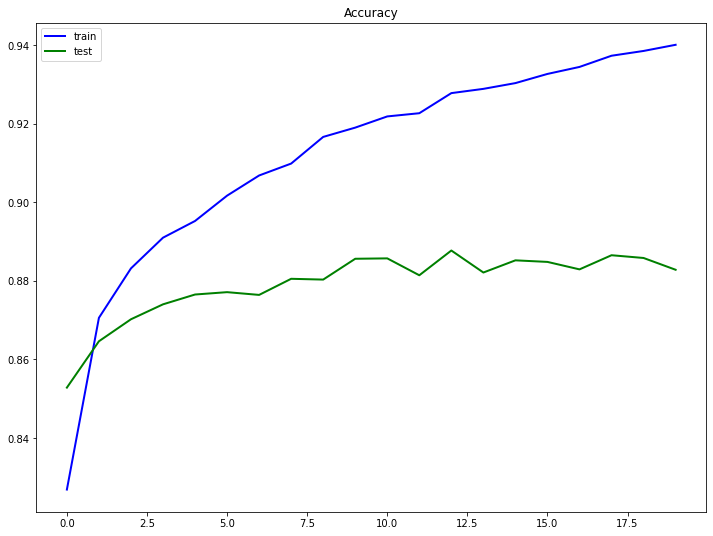

In [ ]:
plot_graph(res)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [ ]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape  * input_channels, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
              ReLU-3                  [-1, 100]               0
            Linear-4                  [-1, 100]          10,100
              ReLU-5                  [-1, 100]               0
            Linear-6                  [-1, 100]          10,100
              ReLU-7                  [-1, 100]               0
            Linear-8                   [-1, 10]           1,010
Total params: 99,710
Trainable params: 99,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.38
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


In [ ]:
model = OverfittingNeuralNetwork().to(device)
res = train_model(model)

train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.7611166666666667


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8248
		f1_score: 0.8243318141664415


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 2
Loader: train. Accuracy: 0.8493


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8494
		f1_score: 0.8459930132998753


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 3
Loader: train. Accuracy: 0.8630166666666667


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8513
		f1_score: 0.8511643149196149


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 4
Loader: train. Accuracy: 0.8735


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8503
		f1_score: 0.8459275180994095


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 5
Loader: train. Accuracy: 0.8786


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8607
		f1_score: 0.8585622535009669


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 6
Loader: train. Accuracy: 0.8852


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8705
		f1_score: 0.8688886094063173


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 7
Loader: train. Accuracy: 0.8902166666666667


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.865
		f1_score: 0.8598397221252639


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 8
Loader: train. Accuracy: 0.8937333333333334


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8762
		f1_score: 0.8748109765100432


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 9
Loader: train. Accuracy: 0.89755


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8743
		f1_score: 0.8750622099559905


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 10
Loader: train. Accuracy: 0.8999333333333334


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8777
		f1_score: 0.8768161947732303


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 11
Loader: train. Accuracy: 0.90475


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8787
		f1_score: 0.8771663923194118


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 12
Loader: train. Accuracy: 0.9074666666666666


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8841
		f1_score: 0.8850738961649274


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 13
Loader: train. Accuracy: 0.90905


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8814
		f1_score: 0.8810341144978826


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 14
Loader: train. Accuracy: 0.9125333333333333


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8813
		f1_score: 0.8815301654296552


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 15
Loader: train. Accuracy: 0.91425


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8825
		f1_score: 0.8825231960638356


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 16
Loader: train. Accuracy: 0.9157333333333333


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8841
		f1_score: 0.8835722138557335


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 17
Loader: train. Accuracy: 0.9195166666666666


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8842
		f1_score: 0.884986210437334


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 18
Loader: train. Accuracy: 0.9211


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8792
		f1_score: 0.879782537687498


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 19
Loader: train. Accuracy: 0.9232


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.884
		f1_score: 0.8845537245028148


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 20
Loader: train. Accuracy: 0.92375


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8796
		f1_score: 0.8811587921009624


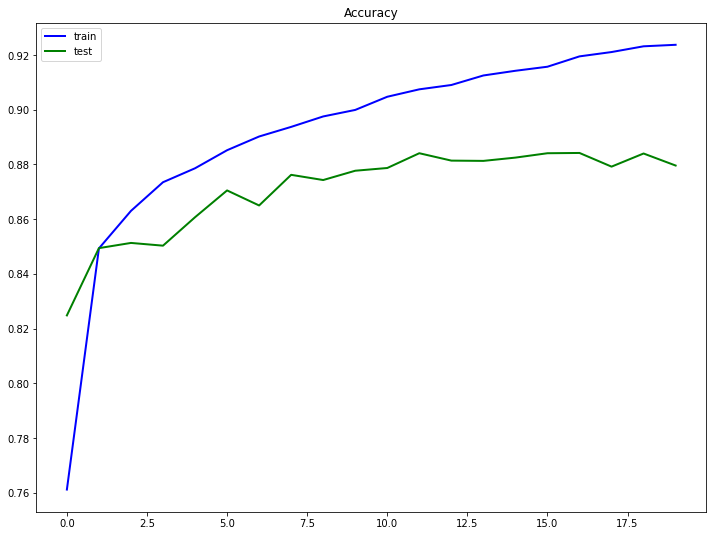

In [ ]:
plot_graph(res)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [ ]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(input_shape  * input_channels),
            nn.Linear(input_shape  * input_channels, 100),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
       BatchNorm1d-2                  [-1, 784]           1,568
            Linear-3                  [-1, 100]          78,500
              ReLU-4                  [-1, 100]               0
            Linear-5                  [-1, 100]          10,100
              ReLU-6                  [-1, 100]               0
           Dropout-7                  [-1, 100]               0
            Linear-8                  [-1, 100]          10,100
              ReLU-9                  [-1, 100]               0
           Linear-10                   [-1, 10]           1,010
Total params: 101,278
Trainable params: 101,278
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.39
Estimated T

In [ ]:
model = FixedNeuralNetwork().to(device)
res = train_model(model)

train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.7893166666666667


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8476
		f1_score: 0.8461272433649574


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 2
Loader: train. Accuracy: 0.8513


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8587
		f1_score: 0.8574203572912799


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 3
Loader: train. Accuracy: 0.86265


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8653
		f1_score: 0.8652196174386146


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 4
Loader: train. Accuracy: 0.8722


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8737
		f1_score: 0.8727954305880109


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 5
Loader: train. Accuracy: 0.87725


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.876
		f1_score: 0.8761033151763398


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 6
Loader: train. Accuracy: 0.8826


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8797
		f1_score: 0.8791171856647001


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 7
Loader: train. Accuracy: 0.8864


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.874
		f1_score: 0.8737925323366575


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 8
Loader: train. Accuracy: 0.8889


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8784
		f1_score: 0.8769109972893944


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 9
Loader: train. Accuracy: 0.89235


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8833
		f1_score: 0.883705479937673


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 10
Loader: train. Accuracy: 0.8962666666666667


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8833
		f1_score: 0.8825835825570495


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 11
Loader: train. Accuracy: 0.8964333333333333


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8847
		f1_score: 0.8841845824687624


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 12
Loader: train. Accuracy: 0.9009833333333334


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8844
		f1_score: 0.8848044975832036


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 13
Loader: train. Accuracy: 0.9034


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8854
		f1_score: 0.8851704570832648


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 14
Loader: train. Accuracy: 0.9049166666666667


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8863
		f1_score: 0.8862796595387739


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 15
Loader: train. Accuracy: 0.9062


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8856
		f1_score: 0.8860322584944722


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 16
Loader: train. Accuracy: 0.9068833333333334


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8875
		f1_score: 0.8863017052462846


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 17
Loader: train. Accuracy: 0.9079


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.889
		f1_score: 0.8887646140433297


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 18
Loader: train. Accuracy: 0.9106666666666666


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8847
		f1_score: 0.8834916164737476


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 19
Loader: train. Accuracy: 0.912


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8877
		f1_score: 0.8865902702214674


train iter::   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 20
Loader: train. Accuracy: 0.9115


test iter::   0%|          | 0/40 [00:00<?, ?it/s]

Loader: test. Accuracy: 0.8891
		f1_score: 0.8891162747764939


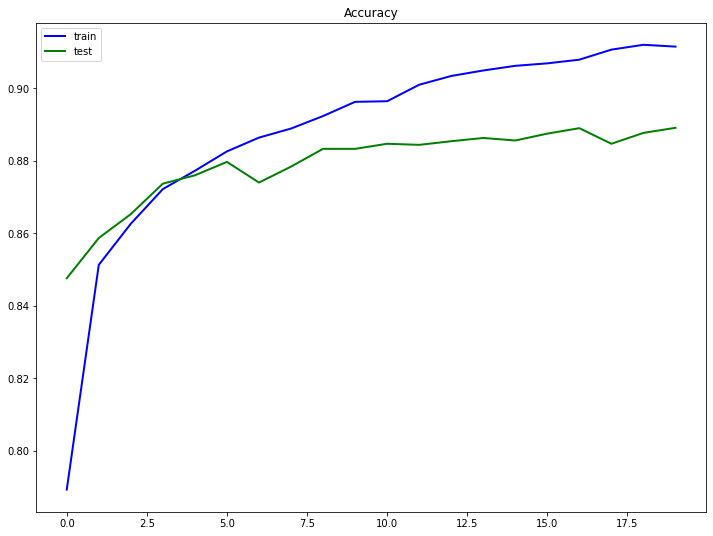

In [ ]:
plot_graph(res)

### Conclusions:
* In the first paragraph, I tried various architectures. But this simple model showed the desired result. I did not succeed in reducing the number of parameters with a valid result.
* To get a retrained model, I added two layers and removed batchnorm and dropout. 
* Accordingly, to get a good model, I added both batchnorm and dropout. I tried to take the dropout probability p = 0.5, but the network was not trained. Therefore, I decided to change this parameter.